In [ ]:
import tensorflow 
import torchaudio.transforms as T
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import torchvision
import  torch
import os
import numpy
import csv
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import random_split, DataLoader, Dataset
import torchaudio
import librosa
import librosa.display
from tqdm import tqdm
from sklearn.preprocessing import normalize
import math
from albumentations import Normalize
import cv2
# from google.colab.patches import cv2_imshow
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from torchvision.models import resnet34
from torch.optim import Adam
from torchmetrics.functional import f1_score
from torch import FloatTensor, LongTensor, DoubleTensor
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from albumentations import Normalize

import warnings
warnings.filterwarnings('ignore')


In [ ]:
bird_list = ['bewwre', 'osprey', 'orcwar', 'comter', 'houspa', 'blujay', 'redcro', 'wesmea', 'amerob', 'marwre', 'bnhcow', 'norcar', 'daejun', 'chispa', 'cangoo', 'norwat', 'wilfly', 'mallar3', 'whbnut', 'rewbla']
keys = set(bird_list)
values = np.arange(0, len(keys))
code_dict = dict(zip(sorted(keys), values))


In [ ]:
path = '../input/bird-audio-image/content/augmented_images/'
df = pd.DataFrame(columns= ['image_path','labels'])

df['image_path'] = [path + folder_path + '/' + image_path for folder_path in bird_list for image_path in os.listdir(path + folder_path)  ]
df['labels'] = [folder_path for folder_path in bird_list for image_path in os.listdir(path + folder_path)  ]

In [ ]:
def to_tensor(data):
    return [FloatTensor(point) for point in data]

# **Data Preparation :**

In [ ]:
class MelDataset(Dataset):
    def __init__(self, df):
        self.aug = Normalize(p=1)
        self.code_dict = code_dict
        self.classes = len(code_dict)
        self.df, self.dataset_length = df, len(df)
        
    def __len__(self):
        return self.dataset_length
    
    def __getitem__(self, i):
        file_name = self.df.image_path[i]
        ebird_code = self.df.labels[i]
        num_code = self.code_dict[ebird_code]
        image = cv2.imread(file_name)
        # image = self.transform(image)
        # image = numpy.array(image)
        code = to_categorical([num_code], num_classes=self.classes)
        return to_tensor([self.aug(image=image)['image'], np.repeat(code, 1, 0)])

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2,random_state=42,stratify=df['labels'])
batch_size = 2


train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

train_set = MelDataset(train_df)
valid_set = MelDataset(valid_df)

valid_loader = DataLoader(valid_set, batch_size=batch_size)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [ ]:
# Check if it's working
for batch, (X, y) in enumerate(train_loader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break

for batch, (X, y) in enumerate(valid_loader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break

Batch: 1
X shape: torch.Size([2, 360, 2160, 3])
y shape: torch.Size([2, 1, 20])
Batch: 1
X shape: torch.Size([2, 360, 2160, 3])
y shape: torch.Size([2, 1, 20])


# **Model : Resnet_34**

In [ ]:
class BirdNet(nn.Module):
    def __init__(self, f, o):
        super(BirdNet, self).__init__()
        self.f = f
        self.dropout = nn.Dropout(p=0.2)
        self.dense_output = nn.Linear(f, o)
        self.resnet = resnet34(pretrained=True)
        ct = 0
        for child in self.resnet.children():
            ct += 1
            if ct < 7:  # Freezed first 6 layers 
                for param in child.parameters():
                    param.requires_grad = False

        self.resnet_head = list(self.resnet.children())
        self.resnet_head = nn.Sequential(*self.resnet_head[:-1])
        


    def forward(self, x):
        x = self.resnet_head(x)
        return self.dense_output(self.dropout(x.view(-1, self.f)))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BirdNet(f=512,o= len(code_dict))
LR = 1e-3, 1e-2
optimizer = Adam([{'params': model.resnet.parameters(), 'lr': LR[0]},
                  {'params': model.dense_output.parameters(), 'lr': LR[1]}])
criterion = torch.nn.CrossEntropyLoss()
model.to(device)


BirdNet(
  (dropout): Dropout(p=0.2, inplace=False)
  (dense_output): Linear(in_features=512, out_features=20, bias=True)
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1

In [ ]:
def get_shuffle_idx(tensor):
    return shuffle(np.arange(len(tensor)))
    
def cel(y_true, y_pred):
    y_true = torch.argmax(y_true, axis=-1)
    return nn.CrossEntropyLoss()(y_pred, y_true)

In [ ]:
f1_score_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": [],
   
}

In [ ]:
class EarlyStopping():
    def __init__(self, loss_tol,val_tol, min_delta):

        self.loss_tol = loss_tol
        self.val_tol = val_tol
        self.min_delta = min_delta
        
        self.counter1 = 0
        self.counter2 = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss , f1_score_stats):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter1 +=1
            if self.counter1 >= self.loss_tol :  
                self.early_stop = True
        
        elif len(f1_score_stats['val']) > 2 and f1_score_stats['val'][-2] > f1_score_stats['val'][-1]:
            self.counter2 +=1
            if self.counter2 >= self.val_tol :  
                self.early_stop = True



early_stopping = EarlyStopping(loss_tol = 5, val_tol = 4 ,min_delta=3)


# **Model Training :**

In [ ]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0   
    valid_loss = 0.0 
    
    ###################
    # train the model #
    ###################
    targets_train = []
    preds_train = []
    model.train()
    
    bar = tqdm(train_loader, total=len(train_loader), leave=False)
    for data in bar:
        train_X, train_y = data
    
        train_y = train_y.view(-1, len(code_dict))
        train_X = train_X.permute(0,3,1,2)
        idx = get_shuffle_idx(train_X)
    
        train_X = train_X[idx].to(device)
        train_y = train_y[idx].to(device)
        
        optimizer.zero_grad()
        
        
        outputs = model(train_X)
        loss = cel(train_y, outputs )    
        targets_train.extend(train_y.cpu().detach().numpy().tolist())
        preds_train.extend(outputs.cpu().detach().numpy().tolist())    
        loss.backward()
        
        optimizer.step()
        
        bar.set_postfix({'loss': loss.item()})
        train_loss += loss.item()*train_X.shape[0]

    preds_train_tensor = torch.tensor(preds_train)
    targets_train_tensor = torch.tensor(targets_train,dtype=torch.int32)
    train_f1_score = f1_score(preds_train_tensor,targets_train_tensor, num_classes=len(code_dict))
        
    ######################    
    # validate the model #
    ######################
    with torch.no_grad():
        targets_val = []
        preds_val = []
        model.eval()
        bar = tqdm(valid_loader, total=len(valid_loader), leave=False)
        for data in bar:
            val_X, val_y = data
            val_y = val_y.view(-1, len(code_dict))
            val_X = val_X.permute(0,3,1,2)
            idx = get_shuffle_idx(val_X)
            val_X = val_X[idx].to(device)
            val_y = val_y[idx].to(device)

            output = model(val_X)
            
            
            # output = model(features)
            loss = cel(val_y, output )       
            
            targets_val.extend(val_y.cpu().detach().numpy().tolist())
            preds_val.extend(output.cpu().detach().numpy().tolist())
            
            # update average validation loss
            valid_loss += loss.item()*val_X.shape[0]
            
    preds_val_tensor = torch.tensor(preds_val)
    targets_val_tensor = torch.tensor(targets_val,dtype=torch.int32)
    val_f1_score = f1_score(preds_val_tensor,targets_val_tensor, num_classes=len(code_dict))
    
    
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)

    loss_stats['train'].append(train_loss)
    loss_stats['val'].append(valid_loss)
    f1_score_stats['train'].append(train_f1_score)
    f1_score_stats['val'].append(val_f1_score)
        
    # print training/validation statistics 
    print('Epoch: {} ----> Train Loss: {:.6f} ----> Train f1_score: {:.6f} ----> Val Loss: {:.6f} ----> Val f1_score: {:.6f}'.format(epoch,train_loss,train_f1_score,valid_loss,val_f1_score ))
    print("*"*200)
    state = {'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(),
             'Train_Loss': train_loss,'Val_Loss': valid_loss,
             'Train_f1': train_f1_score,'Val_f1': val_f1_score,
            }
    torch.save(state, 'model_resnet34_epoch_{}.pt'.format(epoch))

    valid_loss_min = valid_loss

    # Calling early stopping
    early_stopping(train_loss, valid_loss , f1_score_stats)
    if early_stopping.early_stop:
      print("We are at epoch:", epoch)
      break


Epoch: 1 ----> Train Loss: 3.199677 ----> Train f1_score: 0.002646 ----> Val Loss: 3.048552 ----> Val f1_score: 0.000000
********************************************************************************************************************************************************************************************************


Epoch: 2 ----> Train Loss: 3.062709 ----> Train f1_score: 0.007467 ----> Val Loss: 3.006955 ----> Val f1_score: 0.000000
********************************************************************************************************************************************************************************************************


Epoch: 3 ----> Train Loss: 2.986986 ----> Train f1_score: 0.026657 ----> Val Loss: 2.930513 ----> Val f1_score: 0.072801
********************************************************************************************************************************************************************************************************


Epoch: 4 ----> Train Loss: 2.864952 ----> Train f1_score: 0.111938 ----> Val Loss: 2.804690 ----> Val f1_score: 0.170228
********************************************************************************************************************************************************************************************************


Epoch: 5 ----> Train Loss: 2.416174 ----> Train f1_score: 0.239713 ----> Val Loss: 2.334330 ----> Val f1_score: 0.281096
********************************************************************************************************************************************************************************************************


Epoch: 6 ----> Train Loss: 1.923501 ----> Train f1_score: 0.363762 ----> Val Loss: 2.242708 ----> Val f1_score: 0.369072
********************************************************************************************************************************************************************************************************


Epoch: 7 ----> Train Loss: 1.571991 ----> Train f1_score: 0.465202 ----> Val Loss: 2.254098 ----> Val f1_score: 0.448520
********************************************************************************************************************************************************************************************************


Epoch: 8 ----> Train Loss: 1.322001 ----> Train f1_score: 0.540696 ----> Val Loss: 2.035924 ----> Val f1_score: 0.528072
********************************************************************************************************************************************************************************************************


Epoch: 9 ----> Train Loss: 1.145838 ----> Train f1_score: 0.585389 ----> Val Loss: 1.647595 ----> Val f1_score: 0.563964
********************************************************************************************************************************************************************************************************


Epoch: 10 ----> Train Loss: 0.989862 ----> Train f1_score: 0.631100 ----> Val Loss: 1.387481 ----> Val f1_score: 0.606176
********************************************************************************************************************************************************************************************************


Epoch: 11 ----> Train Loss: 0.830255 ----> Train f1_score: 0.671384 ----> Val Loss: 1.489689 ----> Val f1_score: 0.587800
********************************************************************************************************************************************************************************************************


Epoch: 12 ----> Train Loss: 0.704710 ----> Train f1_score: 0.701335 ----> Val Loss: 1.457973 ----> Val f1_score: 0.612646
********************************************************************************************************************************************************************************************************


Epoch: 13 ----> Train Loss: 0.621188 ----> Train f1_score: 0.711813 ----> Val Loss: 1.875824 ----> Val f1_score: 0.612842
********************************************************************************************************************************************************************************************************


Epoch: 14 ----> Train Loss: 0.515552 ----> Train f1_score: 0.744643 ----> Val Loss: 1.519849 ----> Val f1_score: 0.625123
********************************************************************************************************************************************************************************************************


Epoch: 15 ----> Train Loss: 0.435529 ----> Train f1_score: 0.755687 ----> Val Loss: 1.583181 ----> Val f1_score: 0.612022
********************************************************************************************************************************************************************************************************


Epoch: 16 ----> Train Loss: 0.375476 ----> Train f1_score: 0.756616 ----> Val Loss: 2.110677 ----> Val f1_score: 0.618952
********************************************************************************************************************************************************************************************************


Epoch: 17 ----> Train Loss: 0.324019 ----> Train f1_score: 0.769291 ----> Val Loss: 1.674076 ----> Val f1_score: 0.639498
********************************************************************************************************************************************************************************************************


Epoch: 18 ----> Train Loss: 0.287590 ----> Train f1_score: 0.782733 ----> Val Loss: 2.072211 ----> Val f1_score: 0.586839
********************************************************************************************************************************************************************************************************


Epoch: 19 ----> Train Loss: 0.241960 ----> Train f1_score: 0.775937 ----> Val Loss: 1.852735 ----> Val f1_score: 0.655966
********************************************************************************************************************************************************************************************************


Epoch: 20 ----> Train Loss: 0.230281 ----> Train f1_score: 0.783437 ----> Val Loss: 1.615561 ----> Val f1_score: 0.627760
********************************************************************************************************************************************************************************************************
We are at epoch: 20


# **Plots loss and F1_score :**

In [ ]:
# Create dataframes
convert_dict = {'train': float,
                'val': float }  

f1_raw_df = pd.DataFrame.from_dict(f1_score_stats)
f1_raw_df = f1_raw_df.astype(convert_dict) 

loss_raw_df = pd.DataFrame.from_dict(loss_stats)

f1_raw_df.to_csv('f1_score_details.csv',index=False)
loss_raw_df.to_csv('loss_details.csv',index=False)



Text(0.5, 1.0, 'Train-Val Loss/Epoch')

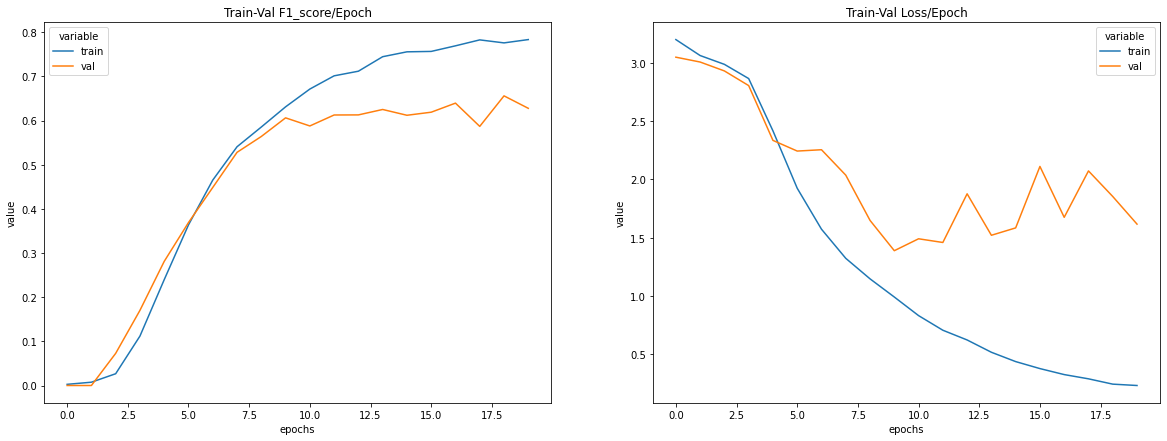

In [ ]:
train_val_f1_df = f1_raw_df.reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = loss_raw_df.reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot the dataframes

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_f1_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val F1_score/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

# **Model Pipeline :**

In [ ]:
def results( model , test_audio):
    hope = 512
    y, sr = librosa.load(test_audio,sr = 50000,duration=20)
    y = y + 0.009*np.random.normal(0,1,len(y))

    rmse = librosa.feature.rms(y, hop_length=hope, center=True)
    spectrogram  = librosa.stft(y)
    mfccs  = librosa.feature.mfcc(y, sr=sr,n_mfcc=50)
    spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))
    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hope)
    times = librosa.times_like(oenv, sr=sr, hop_length=hope)
    tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,hop_length=hope)
    chromagram = librosa.feature.chroma_stft(y, sr=sr, hop_length=hope)

    max_len = max([spectrogram_db.shape[0],mfccs.shape[0],tempogram.shape[0],chromagram.shape[0]])
    max_len_c = max([spectrogram_db.shape[1],mfccs.shape[1],tempogram.shape[1],chromagram.shape[1]])

    spectrogram_db = np.pad(spectrogram_db, [(0, max_len-spectrogram_db.shape[0]), (0, max_len_c-spectrogram_db.shape[1])], mode='constant')
    mfccs = np.pad(mfccs, [(0, max_len-mfccs.shape[0]), (0, max_len_c-mfccs.shape[1])], mode='constant')
    tempogram = np.pad(tempogram, [(0, max_len-tempogram.shape[0]), (0, max_len_c-tempogram.shape[1])], mode='constant')
    chromagram = np.pad(chromagram, [(0, max_len-chromagram.shape[0]), (0, max_len_c-chromagram.shape[1])], mode='constant')

    plt.figure(figsize=(30,5))
    final = (spectrogram_db) +  (mfccs) + tempogram + chromagram + (rmse*100)
    final = normalize(final, axis=1, norm='l1')
    librosa.display.specshow(final , sr=sr, x_axis='time',y_axis='log')
    plt.axis('off')
    plt.savefig('test_audio_image.png')
    plt.clf()
    plt.close()
    aug = Normalize(p=1)
    image = cv2.imread('test_audio_image.png')
    image = FloatTensor(aug(image=image)['image'])
    image = image.permute(2,0,1)
    image = image.view(1,image.shape[0],image.shape[1],image.shape[2])
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device) # Set model to gpu

    
    with torch.no_grad():
        model.eval();
        inputs = image.to(device) 
        pred = model(inputs)
        

    for key, value in code_dict.items():
        if numpy.argmax(pred.cpu()) == value:
            print('predicted bird is:{} '.format(key) , 'actual bird is:{} '.format(test_audio.split('/')[-2]))


# **Prediction using trained Model :**

In [ ]:
filepath = './model_resnet34_epoch_20.pt'
state = torch.load(filepath)
model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])


In [ ]:
path = '../input/bird-audio-data/content/train_audio/'
df = pd.DataFrame(columns= ['audio_path','labels'])
df['audio_path'] = [path + folder_path + '/' + image_path for folder_path in bird_list for image_path in os.listdir(path + folder_path)  ]
df['labels'] = [folder_path for folder_path in bird_list for image_path in os.listdir(path + folder_path)  ]


In [ ]:
import random
for i in range(15):
    test_audio = df.iloc[random.randint(1,len(df))].audio_path
    
    results( model ,test_audio)

predicted bird is:marwre  actual bird is:daejun 
predicted bird is:mallar3  actual bird is:mallar3 
predicted bird is:bnhcow  actual bird is:bnhcow 
predicted bird is:marwre  actual bird is:marwre 
predicted bird is:comter  actual bird is:cangoo 
predicted bird is:marwre  actual bird is:daejun 
predicted bird is:cangoo  actual bird is:cangoo 
predicted bird is:daejun  actual bird is:daejun 
predicted bird is:cangoo  actual bird is:cangoo 
predicted bird is:marwre  actual bird is:whbnut 
predicted bird is:blujay  actual bird is:blujay 
predicted bird is:wesmea  actual bird is:wesmea 
predicted bird is:rewbla  actual bird is:rewbla 
predicted bird is:bewwre  actual bird is:bewwre 
predicted bird is:chispa  actual bird is:chispa 


# **Observation :**


*   After performing data augmentation with additional data , model behaved as expected
*   The model data is a combination of extracted features and augmentation, which was converted to image so that it became a CNN classification problem.


*   Most of Audio data is blurry as the sound was very unclear in few recordings. Few of the extracted images after augmentations are as below:






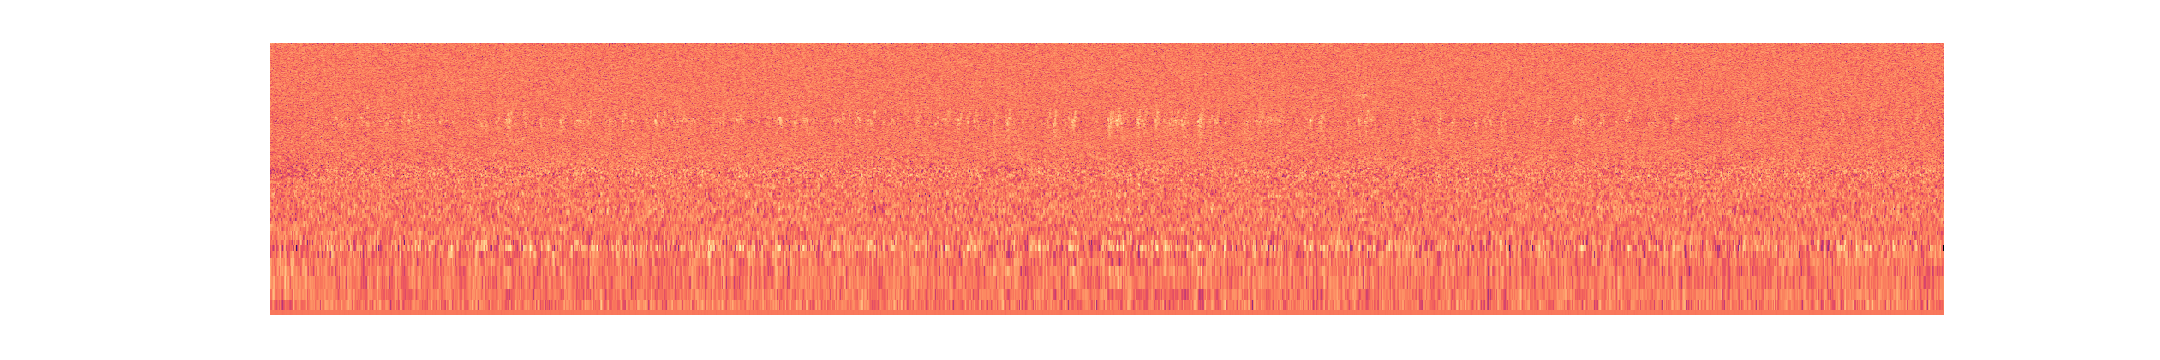

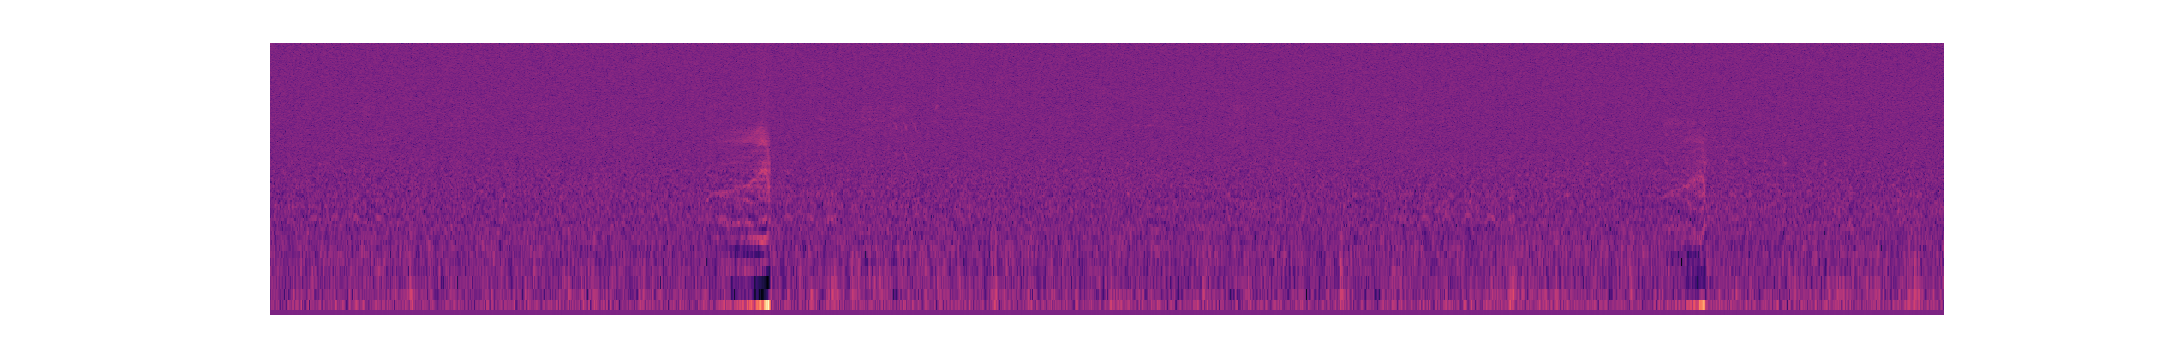

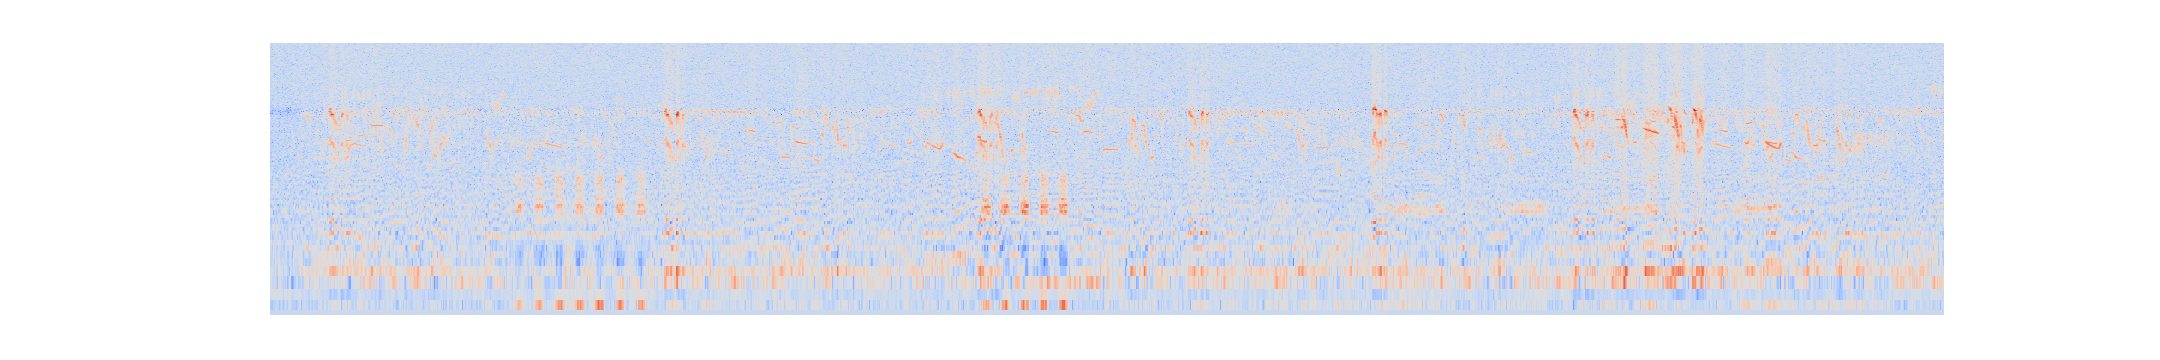